In [1]:
import matplotlib.pyplot as plt
import torch
from models_dif import SoftmaxWeight, LocationScaleFlow, DIFDensityEstimator

number of samples = 60000


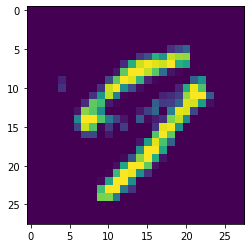

In [2]:
###MNIST###

import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
images = mnist_trainset.data.flatten(start_dim=1)
targets = mnist_trainset.targets

digit = 'all'
if digit != 'all':
    extracted = images[targets == digit].float()
else: 
    extracted = images.float()
target_samples = extracted

num_samples  = target_samples.shape[0]
print('number of samples = ' + str(num_samples))
p = target_samples.shape[-1]
plt.imshow(target_samples[torch.randint(low = 0, high = num_samples, size = [1])].reshape(28,28))

train_set, test_set = target_samples[:4000], target_samples[4000:]

In [5]:
K = 20
dif = DIFDensityEstimator(target_samples, K)
dif.w = SoftmaxWeight(K,p, [10,10,10])
dif.train(200, 5000)

  1%|█▊                                                                                                                                                                             | 2/200 [00:42<1:09:30, 21.06s/it, loss = 1580589.125]


KeyboardInterrupt: 

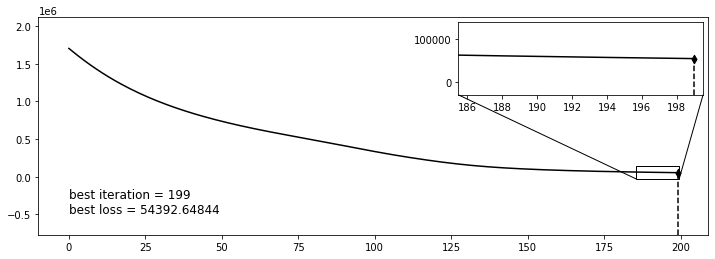

In [7]:
### Visualize training ###
model_to_visualize = dif

import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

loss_values = dif.loss_values
best_loss = min(loss_values)
best_iteration = loss_values.index(best_loss)
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
Y1, Y2 = best_loss - (max(loss_values) -best_loss) / 2, max(loss_values) + (max(loss_values) - best_loss) / 4
ax.set_ylim(Y1, Y2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(loss_values, label='Loss values during training', color='black')
ax.scatter([best_iteration], [best_loss], color='black', marker='d')
ax.axvline(x=best_iteration, ymax=(best_loss -best_loss + (max(loss_values) - best_loss) / 2) / (
        max(loss_values) + (max(loss_values) - best_loss) / 4 - best_loss + (
        max(loss_values) - best_loss) / 2), color='black', linestyle='--')
ax.text(0, best_loss - (max(loss_values) - best_loss) / 8,
        'best iteration = ' + str(best_iteration) + '\nbest loss = ' + str(np.round(best_loss, 5)),
        verticalalignment='top', horizontalalignment='left', fontsize=12)
if len(loss_values) > 30:
    x1, x2 = best_iteration - int(len(loss_values) / 15), min(best_iteration + int(len(loss_values) / 15),
                                                              len(loss_values) - 1)
    k = len(loss_values) / (2.5 * (x2 - x1 + 1))
    offset = (Y2 - Y1) / (6 * k)
    y1, y2 = best_loss - offset, best_loss + offset
    axins = zoomed_inset_axes(ax, k, loc='upper right')
    axins.axvline(x=best_iteration, ymax=(best_loss - y1) / (y2 - y1), color='black', linestyle='--')
    axins.scatter([best_iteration], [best_loss], color='black', marker='d')
    axins.xaxis.set_major_locator(MaxNLocator(integer=True))
    axins.plot(loss_values, color='black')
    axins.set_xlim(x1 - .5, x2 + .5)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=3, loc2=4)

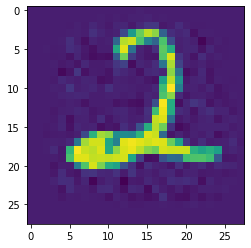

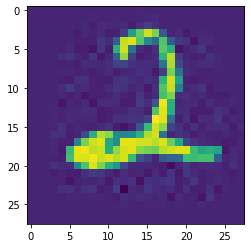

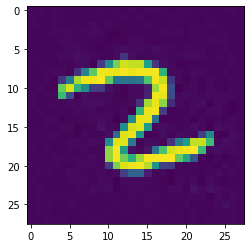

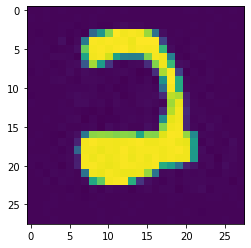

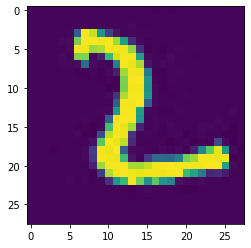

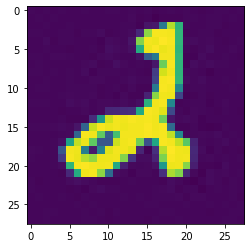

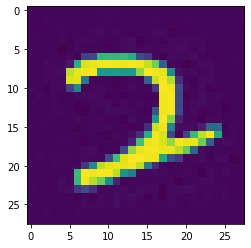

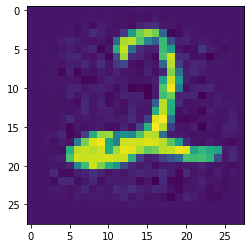

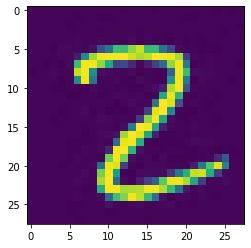

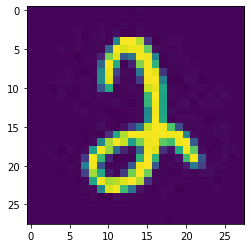

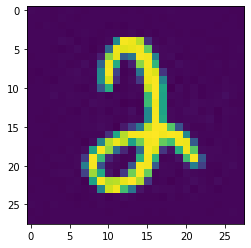

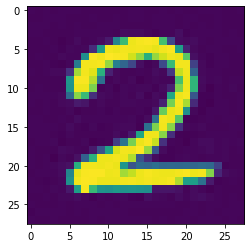

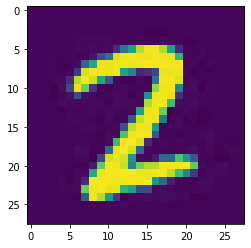

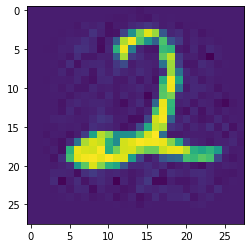

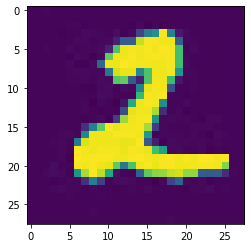

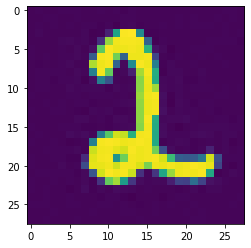

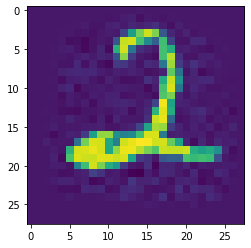

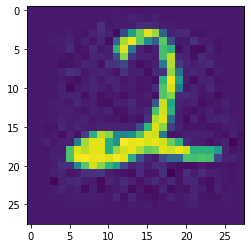

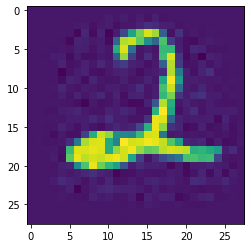

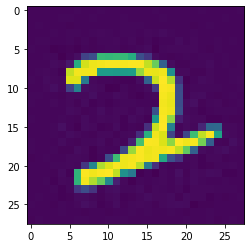

In [8]:
for _ in range(20):
    plt.figure()
    sample = dif.sample_model(1)
    plt.imshow(sample[0].reshape(28,28))